# Homework #2 - Programming: Embedding Space
### Embedding Space Exploration and Semantic Transformation

load data

Word embedding datasets source: https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation

In [3]:
# load data
from gensim.models.keyedvectors import KeyedVectors

path_to_glove_file = 'archive/glove.6B.100d.txt'

# Load the GloVe model
glove_model = KeyedVectors.load_word2vec_format(path_to_glove_file, no_header=True, binary=False)

**Exploring Word Embeddings**

In [4]:
# Exploring Semantic Relationships...
# Finding Nearest Neighbors
def nearest_neighbors(word, model, topn=5):
    return model.most_similar(word, topn=topn)

# Example
print(nearest_neighbors("computer", glove_model))


[('computers', 0.8751983046531677), ('software', 0.8373122215270996), ('technology', 0.7642159461975098), ('pc', 0.7366448640823364), ('hardware', 0.7290390729904175)]


In [5]:
# Algebraic Operations
def algebraic_operations(a, b, c, model):
    return model.most_similar(positive=[c, b], negative=[a])

# Example
print(algebraic_operations('man', 'king', 'woman', glove_model))


[('queen', 0.7698541283607483), ('monarch', 0.6843380331993103), ('throne', 0.6755736470222473), ('daughter', 0.6594556570053101), ('princess', 0.6520534157752991), ('prince', 0.6517034769058228), ('elizabeth', 0.6464518308639526), ('mother', 0.631171703338623), ('emperor', 0.6106470823287964), ('wife', 0.6098655462265015)]


**Visualization of Embedding Spaces**

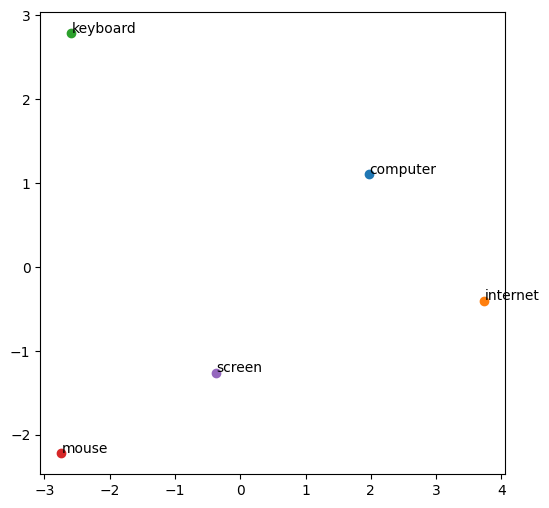

In [6]:
#Visualization of Embedding Spaces
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_embeddings(words, model):
    vectors = [model[word] for word in words]
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)
    
    plt.figure(figsize=(6,6))
    for word, vec in zip(words, vectors_2d):
        plt.scatter(vec[0], vec[1])
        plt.text(vec[0]+0.01, vec[1]+0.01, word)
    plt.show()

# Example
plot_embeddings(['computer', 'internet', 'keyboard', 'mouse', 'screen'], glove_model)


**Transforming Embeddings**

Bias Reduction

In [20]:
# Transforming Embeddings for a Specific Task - Bias Reduction
# Identifying Gender Bias
gender_direction = glove_model['man'] - glove_model['woman']

def gender_bias(word, model):
    return model[word].dot(gender_direction)

# Example
print(gender_bias('nurse', glove_model))
print(gender_bias('engineer', glove_model))


-6.007044
2.2983837


It illustrates how 'nurse' is more associated with 'woman' and 'engineer' with 'man'.

In [8]:
# Mitigating Gender Bias
def debias(word, model):
    bias = gender_bias(word, model)
    debiased_vector = model[word] - bias * gender_direction
    return debiased_vector

# Example
nurse_debiased = debias('nurse', glove_model)


text classification

Dataset source: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

In [42]:
# Applying the Transformed Embeddings (Sentiment Analysis)
import pandas as pd
reviews = pd.read_csv('twitter_training.csv')
reviews.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [43]:
reviews.Positive.value_counts()

Positive
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [44]:
# for the simplicity of the task, we will only consider the positive and negative reviews, and drop the neutral ones and irrelevant ones
reviews = reviews[reviews.Positive != 'Neutral']
reviews = reviews[reviews.Positive != 'Irrelevant']

In [45]:
# map the positive reviews to 1, and negative reviews to 0
reviews['labels'] = reviews['Positive'].map({'Negative': 0, 'Positive': 1})
reviews.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,",labels
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,1
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,1
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,1
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,1
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,1


In [46]:
# rename the column 'TweetText' to 'text'
reviews = reviews.rename(columns={'im getting on borderlands and i will murder you all ,': 'text'})

In [47]:
sentiments = reviews['labels']
reviews = reviews['text']

In [53]:
import numpy as np

# Function to convert text to average GloVe vector
def text_to_vector(text, model):
    words = text.split()
    word_vectors = np.array([model[word] for word in words if word in model])
    
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    
    return np.mean(word_vectors, axis=0)

# Create feature vectors for each review
X = np.array([text_to_vector(str(review), glove_model) for review in reviews])
y = np.array(sentiments)


In [54]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [55]:
from sklearn.linear_model import LogisticRegression

# Train a logistic regression classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [56]:
from sklearn.metrics import accuracy_score

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 72.15%


In [57]:
# Example of classifying a new review
new_review = "I am not satisfied with the product"
new_review_vector = text_to_vector(new_review, glove_model).reshape(1, -1)
prediction = classifier.predict(new_review_vector)

print(f"The sentiment of the new review is: {'positive' if prediction[0] == 1 else 'negative'}")


The sentiment of the new review is: negative
